
# 📘 Coffee Recommender Comparison — TF‑IDF vs Word2Vec

This notebook builds **two hybrid recommender models** on the dataset:

1. **TF‑IDF + numeric features**  
2. **Word2Vec + numeric features**

Both models combine similarity from six sensory attributes:

- Agtron
- Aroma
- Acid
- Body
- Flavor
- Aftertaste

with textual similarity derived from the coffee descriptions.


In [1]:

import pandas as pd
import numpy as np
import re, os, sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.max_colwidth', 50)

# === 1. Load dataset ===
df = pd.read_csv('datasets\coffee_df_with_type_and_region.csv')
print(f"Loaded {len(df):,} rows")
df.head()

Loaded 2,282 rows


,slug,all_text,rating,roaster,name,region_africa_arabia,region_caribbean,region_central_america,region_hawaii,region_asia_pacific,...,agtron,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3
0,https://www.coffeereview.com/review/wilton-ben...,\r\n\r\n\r\n95\r\n\r\n\r\nJBC Coffee Roasters...,95,JBC Coffee Roasters,Wilton Benitez Geisha,0,0,0,0,0,...,59/81,9.0,9.0,9.0,9.0,9.0,NaN,"Richly floral-toned, exceptionally sweet. Dist...",Produced by Wilton Benitez of Macarena Farm en...,"A nuanced, complex experimentally processed Co..."
1,https://www.coffeereview.com/review/colombia-c...,\r\n\r\n\r\n95\r\n\r\n\r\nBird Rock Coffee Ro...,95,Bird Rock Coffee Roasters,Colombia Cerro Azul Geisha,0,0,0,0,0,...,62/80,9.0,9.0,9.0,9.0,9.0,NaN,"Richly aromatic, chocolaty, fruit-toned. Dark ...",Produced by Rigoberto Herrera of Granja La Esp...,"A trifecta of fruit, chocolate and flowers, bo..."
2,https://www.coffeereview.com/review/yirgacheff...,\r\n\r\n\r\n94\r\n\r\n\r\nRegent Coffee\r\nYi...,94,Regent Coffee,Yirgacheffe Mengesha Natural,1,0,0,0,0,...,60/77,9.0,9.0,9.0,9.0,8.0,NaN,"High-toned, fruit-driven. Boysenberry, pear, c...",Produced at Mengesha Farm from selections of i...,A fruit medley in a cup — think boysenberry an...
3,https://www.coffeereview.com/review/colombia-t...,\r\n\r\n\r\n93\r\n\r\n\r\nRegent Coffee\r\nCo...,93,Regent Coffee,Colombia Tolima Finca El Mirador Washed Anaerobic,0,0,0,0,0,...,59/79,9.0,9.0,8.0,9.0,8.0,NaN,"Delicately fruit-toned. Guava, ginger blossom,...",Produced by Victor Gutiérrez of Finca Mirador ...,"An appealing washed anaerobic cup: deep-toned,..."
4,https://www.coffeereview.com/review/panama-gei...,\r\n\r\n\r\n94\r\n\r\n\r\nTheory Coffee Roast...,94,Theory Coffee Roasters,Panama Geisha Finca Debra Symbiosis,0,0,1,0,0,...,62/80,9.0,9.0,9.0,9.0,8.0,NaN,"Richly fruit-forward, floral-toned. Lychee, te...",Produced by Jamison Savage of Finca Debra enti...,A floral- and fruit-driven anaerobic natural P...


In [3]:

# === 2. Preprocess ===
FEATURES = ['agtron', 'aroma', 'acid', 'body', 'flavor', 'aftertaste']
DESC_COLS = ['desc_1', 'desc_2', 'desc_3']

def convert_to_float(val):
    """Convert ratio or numeric strings to float."""
    if isinstance(val, str) and '/' in val:
        try:
            num, denom = val.split('/')
            return float(num) / float(denom)
        except Exception:
            return None
    try:
        return float(val)
    except Exception:
        return None

# Convert agtron
df['agtron'] = df['agtron'].apply(convert_to_float)

# Combine text columns
df['full_desc'] = df[DESC_COLS].fillna('').agg(' '.join, axis=1)

def preprocess_description(text: str) -> str:
    text = text.lower().strip()
    patterns_to_remove = [
        r"^i (would like|want|am looking|feel like)( to)?( have| try| taste| get)?( a| some)?",
        r"^i (need|prefer|love|crave)( a| some)?",
        r"^looking for( a| some)?",
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['full_desc'] = df['full_desc'].apply(preprocess_description)

# Drop rows with missing numeric features
before = len(df)
df.dropna(subset=FEATURES, inplace=True)
after = len(df)
print(f'Dropped {before-after} rows due to missing numeric features; remaining: {after}')


Dropped 371 rows due to missing numeric features; remaining: 1911


In [4]:

# Min‑Max scale numeric features to [0,1]
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])


In [5]:

# === 3. Vectorise descriptions with TF‑IDF ===
tfidf = TfidfVectorizer(stop_words='english')
desc_tfidf = tfidf.fit_transform(df['full_desc'])
print("TF‑IDF matrix shape:", desc_tfidf.shape)


TF‑IDF matrix shape: (1911, 6753)


In [6]:

# === 4. Load Word2Vec ===
# Uses gensim downloader to fetch small model (~127 MB) automatically on first run.
W2V_MODEL_NAME = 'glove-wiki-gigaword-100'  # smaller; switch to 'word2vec-google-news-300' if have the disk & time
print(f'Loading...')
w2v = api.load(W2V_MODEL_NAME)  # cached after first download
print("Embedding dimension:", w2v.vector_size)

def get_avg_vector(text: str, model) -> np.ndarray:
    tokens = simple_preprocess(text)
    vecs = [model[t] for t in tokens if t in model]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

# Pre‑compute coffee description vectors
desc_w2v = np.vstack([get_avg_vector(t, w2v) for t in df['full_desc']])


Loading...
Embedding dimension: 100


In [7]:

# === 5. Define a sample user profile ===
user_prefs = dict(zip(
    FEATURES,
    [0.5, 0.8, 0.6, 0.5, 0.7, 0.4]   # <-- customise here
))
user_text = "I want a fruity coffee with low acidity and medium body"
clean_text = preprocess_description(user_text)

# user_desc = 'fruity coffee with low acidity and medium body'
# user_prefs = {
#     'agtron': 0.50,
#     'aroma': 0.75,
#     'acid': 0.40,
#     'body': 0.60,
#     'flavor': 0.80,
#     'aftertaste': 0.35,
# }


In [8]:

# === 6. Compute similarities ===
# Numeric similarity
coffee_numeric = df[FEATURES].values
user_numeric_vec = np.array([user_prefs[f] for f in FEATURES])
dist = np.linalg.norm(coffee_numeric - user_numeric_vec, axis=1)
numeric_sim = 1 - (dist - dist.min()) / (dist.max() - dist.min())

# TF‑IDF similarity
user_tfidf = tfidf.transform([clean_text])
text_sim_tfidf = cosine_similarity(user_tfidf, desc_tfidf).flatten()

# Word2Vec similarity
user_w2v_vec = get_avg_vector(clean_text, w2v).reshape(1, -1)
text_sim_w2v = cosine_similarity(user_w2v_vec, desc_w2v).flatten()

alpha = 0.5  # weight for numeric vs text
df['sim_tfidf'] = alpha * numeric_sim + (1-alpha) * text_sim_tfidf
df['sim_w2v']  = alpha * numeric_sim + (1-alpha) * text_sim_w2v


In [20]:

# === 7. Show Top‑N recommendations ===
TOP_N = 5
display_cols = ['name', 'roaster', 'desc_1', 'sim_tfidf', 'sim_w2v']

top_tfidf = df.nlargest(TOP_N, 'sim_tfidf')[display_cols]
top_w2v  = df.nlargest(TOP_N, 'sim_w2v')[display_cols]

print("Top‑%d by TF‑IDF + numeric:" % TOP_N)
display(top_tfidf)

print("\nTop‑%d by Word2Vec + numeric:" % TOP_N)
display(top_w2v)

# Compute overlap
overlap = len(set(top_tfidf.index) & set(top_w2v.index)) / TOP_N
print(f"Top‑{TOP_N} overlap: {overlap*100:.1f}%")

from sentence_transformers import SentenceTransformer
print("Encoding descriptions with SBERT (first run may download model)...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
M_sbert = sbert_model.encode(df['full_desc'].tolist(), show_progress_bar=True)

# Encode user query
user_sbert_vec = sbert_model.encode([clean_text])

# Similarity scores
sim_sbert_text = cosine_similarity(user_sbert_vec, M_sbert).flatten()
combined_sbert = alpha * numeric_sim + (1 - alpha) * sim_sbert_text
df['sim_sbert'] = combined_sbert

# Top‑N list
top_idx_sbert = np.argsort(combined_sbert)[::-1][:TOP_N]
print("\nTop‑{0} by SBERT + numeric:".format(TOP_N))
display(df.iloc[top_idx_sbert][['name','roaster']].assign(sim_sbert=combined_sbert[top_idx_sbert]))



Top‑5 by TF‑IDF + numeric:


,name,roaster,desc_1,sim_tfidf,sim_w2v
736,Bolivia Finca El Arcangel,Hidden Coffee HK,"Crisply sweet, delicately aromatic. Hazelnut, ...",0.528152,0.933825
141,Purple Tipsy Night,David's Nose,"Tart-leaning, fruity-sweet. Raspberry, cocoa p...",0.525175,0.950236
1259,Taiwan Natural Medium Roast,The Formosa Coffee,"Sweet-toned, fruit-centered. Raisin, brown sug...",0.521717,0.927179
1789,Natural Burundi Nemba,Amavida Coffee Roasters,"Round, layered, sweet-savory, understated but ...",0.521235,0.921766
243,Rwanda Karambi Station Natural,RamsHead Coffee Roasters,"Crisply tart, sweetly herbaceous. Tangerine, t...",0.516982,0.899726



Top‑5 by Word2Vec + numeric:


,name,roaster,desc_1,sim_tfidf,sim_w2v
141,Purple Tipsy Night,David's Nose,"Tart-leaning, fruity-sweet. Raspberry, cocoa p...",0.525175,0.950236
1054,Ecuador La Hormiga “Naty”,Paradise Roasters,"Delicately sweet-tart. Candy apple, green bana...",0.501931,0.942244
716,Rwanda Abakundakawa,Fresh Roasted Coffee,"Sweet-toned, gently floral. Baking chocolate, ...",0.494775,0.939926
13,Mexico La Peña,SkyTop Coffee,"Crisply sweet, citrusy and bright. Orange zest...",0.496757,0.939722
1595,Butare Huye of Rwanda,San Francisco Bay Coffee,"Richly sweet, balanced. Orange zest, baking ch...",0.498035,0.938065


Top‑5 overlap: 20.0%
Encoding descriptions with SBERT (first run may download model)...


Batches:   0%|          | 0/60 [00:00<?, ?it/s]


Top‑5 by SBERT + numeric:


,name,roaster,sim_sbert
1652,Ethiopia Yirgacheffe Adorsi,Small Eyes Cafe,0.801364
2194,Ethiopia Reko,Java Blend Coffee Roasters,0.791377
1054,Ecuador La Hormiga “Naty”,Paradise Roasters,0.787446
2148,COE Brazil Naturals 2017 Sitio Esperanza 7th p...,Dragonfly Coffee Roasters,0.785680
1712,La Avila SL28 El Salvador,PT's Coffee Roasting Co.,0.782802


In [26]:
# ==========================================================
# Evaluation metrics (Top-N)  ▸  TF-IDF  vs  Word2Vec  vs  SBERT
# ==========================================================
import itertools
from sklearn.metrics.pairwise import cosine_similarity

TOP_N = 5  # ubah sesuai kebutuhan

# ---------- 1. Ambil indeks Top-N ----------
# gunakan skor gabungan (numeric + text) jika ada;
# fallback ke text-only score variabel lama
try:
    top_idx_tfidf = np.argsort(sim_tfidf)[::-1][:TOP_N]
except NameError:
    top_idx_tfidf = np.argsort(text_sim_tfidf)[::-1][:TOP_N]

try:
    top_idx_w2v   = np.argsort(sim_w2v)[::-1][:TOP_N]
except NameError:
    top_idx_w2v   = np.argsort(text_sim_w2v)[::-1][:TOP_N]

try:
    top_idx_sbert = np.argsort(sim_sbert)[::-1][:TOP_N]
except NameError:
    # jika pakai nama lain (combined_sbert)
    top_idx_sbert = np.argsort(combined_sbert)[::-1][:TOP_N]

# ---------- 2. Jaccard Overlap ----------
def jaccard(a, b):
    return len(set(a) & set(b)) / len(set(a) | set(b))

print("Jaccard overlap:")
print(f"  TF-IDF vs W2V   : {jaccard(top_idx_tfidf, top_idx_w2v):.2f}")
print(f"  TF-IDF vs SBERT : {jaccard(top_idx_tfidf, top_idx_sbert):.2f}")
print(f"  W2V   vs SBERT  : {jaccard(top_idx_w2v,  top_idx_sbert):.2f}")

# ---------- 3. Intra-List Diversity (ILD) ----------
#  Pastikan matriks cosine global sudah ada
try:
    global_cos
except NameError:
    # bangun dari TF-IDF matrix
    if 'M_tfidf' not in globals():
        tfidf_vec = TfidfVectorizer(stop_words="english")
        M_tfidf   = tfidf_vec.fit_transform(df["full_desc"])
    global_cos = cosine_similarity(M_tfidf)

def ild(indices, sim_matrix):
    if len(indices) < 2:
        return 0.0
    sims = [sim_matrix[i, j] for i, j in itertools.combinations(indices, 2)]
    return 1 - np.mean(sims)

ild_tfidf = ild(top_idx_tfidf, global_cos)
ild_w2v   = ild(top_idx_w2v,   global_cos)
ild_sbert = ild(top_idx_sbert, global_cos)

print("\nILD scores")
print(f"  TF-IDF : {ild_tfidf:.6f}")
print(f"  W2V    : {ild_w2v:.6f}")
print(f"  SBERT  : {ild_sbert:.6f}")


Jaccard overlap:
  TF-IDF vs W2V   : 0.00
  TF-IDF vs SBERT : 0.00
  W2V   vs SBERT  : 0.00

ILD scores
  TF-IDF : 0.889191
  W2V    : 0.903185
  SBERT  : 0.899133


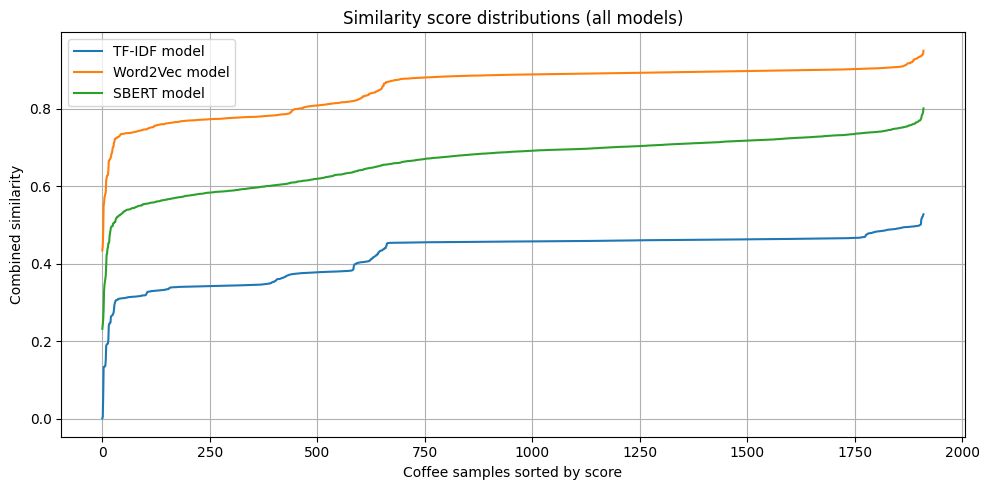

In [21]:
# === 8. Visualise similarity distributions (3 models) ===
plt.figure(figsize=(10,5))

# urutkan skor dari kecil → besar agar kurva mulus
plt.plot(df['sim_tfidf'].sort_values().values,
         label='TF-IDF model')
plt.plot(df['sim_w2v'].sort_values().values,
         label='Word2Vec model')
plt.plot(df['sim_sbert'].sort_values().values,
         label='SBERT model')

plt.title('Similarity score distributions (all models)')
plt.xlabel('Coffee samples sorted by score')
plt.ylabel('Combined similarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Why was the top TF‑IDF coffee recommended?

In [28]:
item_idx = top_idx_tfidf[0] # first recommendation from TF-IDF
item_row = df.iloc[item_idx]
top_terms = tfidf_vec.inverse_transform(M_tfidf[item_idx])[0][:3]
delta = {f: item_row[f] - user_prefs[f] for f in FEATURES}

print('Coffee:', item_row['name'])
print('Top keywords:', ', '.join(top_terms))
print('Full Desc:', item_row['full_desc'])
print('Δ sensory (item - pref):')
for k, v in delta.items():
    print(f' {k:<10s}: {v:+.2f}')


item_idx_w2v = top_idx_w2v[0]  # first recommendation from Word2Vec
item_row_w2v = df.iloc[item_idx_w2v]
top_terms_w2v = tfidf_vec.inverse_transform(M_tfidf[item_idx_w2v])[0][:3]
delta_w2v = {f: item_row_w2v[f] - user_prefs[f] for f in FEATURES}
item_idx_sbert = top_idx_sbert[0]          # first recommendation from SBERT
item_row_sbert = df.iloc[item_idx_sbert]

print('\nCoffee (Word2Vec):', item_row_w2v['name'])
print('Full Desc:', item_row_w2v['full_desc'])
print('Top keywords:', ', '.join(top_terms_w2v))
print('Δ sensory (item - pref):')
for k, v in delta_w2v.items():
    print(f' {k:<10s}: {v:+.2f}')

# Keyword extraction masih pakai TF-IDF vocab
top_terms_sbert = tfidf_vec.inverse_transform(M_tfidf[item_idx_sbert])[0][:3]

delta_sbert = {f: item_row_sbert[f] - user_prefs[f] for f in FEATURES}

print('\nCoffee (SBERT):', item_row_sbert['name'])
print('Full Desc:', item_row_sbert['full_desc'])
print('Top keywords (TF-IDF lens):', ', '.join(top_terms_sbert))
print('Δ sensory (item - pref):')
for k, v in delta_sbert.items():
    print(f' {k:<10s}: {v:+.2f}')


Coffee: Ethiopia Gera Estate Anaerobic Natural
Top keywords: evocative, dessert, gera
Full Desc: tropically fruity, richly chocolaty. dried blueberry, lychee, chocolate fudge, cedar, wisteria in aroma and cup. brightly sweet-tart structure with winy acidity; plush, very viscous mouthfeel. long, resonant, flavor-saturated finish. produced at gera estate from trees of selections of indigenous landrace varieties of ethiopia arabica, and processed by the natural anaerobic method, wherein whole fruit is fermented with limited oxygen before drying. magnolia coffee is a charlotte-based specialty roaster whose mission is to use sustainably sourced coffees to make a difference in the lives of coffee workers and to foster a socially conscious community with cause-supporting coffees. visit www.magnoliacoffeeco.com for more information. a dessert-like ethiopia anaerobic natural: chocolaty, fruit-driven and deep, evocative of a tropical fruit melange, with vibrant acidity and lush body.
Δ sensory (